In [39]:
import torch
from torch import nn, optim
import torchdiffeq as tdf
from matplotlib import pyplot as plt
import numpy as np

In [40]:
device="cpu"

In [41]:
def generate_spiral2d(nspiral=1000, ntotal=500, nsample=100, start = 0., stop = 1., noise_std=.1, a=0., b=1.):
    orig_ts = torch.linspace(start, stop, ntotal)
    samp_ts = orig_ts[:nsample]
    
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * torch.cos(zs_cw) - 5., rs_cw * torch.sin(zs_cw)
    orig_traj_cw = torch.stack((xs, ys), dim=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * torch.cos(zs_cc) + 5., rw_cc * torch.sin(zs_cc)
    orig_traj_cc = torch.stack((xs, ys), dim=1)
    
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        t0_idx = torch.multinomial(torch.ones(ntotal - int(2 * nsample)), 1)
        t0_idx += nsample
        
        # cc = bool(torch.rand(1) > .5)
        cc = True
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)
        
        samp_traj = orig_traj[t0_idx:t0_idx+nsample].clone()
        samp_traj += torch.randn_like(samp_traj) * noise_std
        samp_trajs.append(samp_traj)
    
    samp_trajs = torch.stack(samp_trajs, dim=0)
    orig_trajs = torch.stack(orig_trajs, dim=0)
    return orig_trajs, samp_trajs, samp_ts, orig_ts
    # return orig_traj_cc, orig_traj_cw
    
    

In [42]:
generate_spiral2d()[0].size()

torch.Size([1000, 500, 2])

In [43]:
class LatentODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.model = nn.Sequential(
            nn.ELU(inplace=True),
            nn.Linear(latent_dim, nhidden),
            nn.Linear(nhidden, nhidden),
            nn.Linear(nhidden, latent_dim)
        )
        self.nfe = 0
    
    def forward(self, t, x):
        self.nfe += 1
        return self.model(x)


In [50]:
if __name__ == "__main__":
    RecognitionRNN()

AttributeError: module 'torch.nn' has no attribute 'Lienar'

In [51]:
class RecognitionRNN(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nbatch = nbatch
        self.nhidden = nhidden
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        
    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h
    
    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)
    


In [59]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ReLU(inplace=True),
            nn.Linear(nhidden, obs_dim),
        )
    
    def forward(self, z):
        return self.model(z)

$$
p(x) = \frac{1}{\sqrt{2\pi }\sigma} \exp\left\{ - \frac{(x - \mu)^{2}}{2\sigma^{2}} \right\}
$$

The equation for the log-normal probability density function (PDF) is given by:

$$
p(x) = \frac{1}{x\sigma\sqrt{2\pi}} \exp\left\{ - \frac{(\ln(x) - \mu)^{2}}{2\sigma^{2}} \right\}
$$

where $x$ is the variable, $\mu$ is the mean of the logarithm of $x$, and $\sigma$ is the standard deviation of the logarithm of $x$.

In [46]:
def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


$$
\begin{split}
D_{\text{KL}}[\mathcal{N}(\mu_{0},\Sigma_{0})&\Vert \mathcal{N}(\mu_{1},\Sigma_{1})] = \\
& \frac{1}{2} \left( \text{Tr}(\Sigma_{1}^{-1}\Sigma_{0}) + (\mu_{1}-\mu_{0})^{T}\Sigma_{1}^{-1}(\mu_{1}-\mu_{0})- k + \log\left( \frac{\det\Sigma_{1}}{\det\Sigma_{0}} \right) \right)
\end{split}
$$


In [47]:
def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = .5 * lv1
    lstd2 = .5 * lv2
    
    kl = 1/2 * ((mu1 - mu2) ** 2 / v2 + v1 / v2 - 1. + 2 * (lstd2 - lstd1))
    return kl

In [79]:
if __name__ == '__main__':
    latent_dim = 4
    nhidden = 20
    rnn_nhidden = 25
    obs_dim = 2
    nspiral = 1000
    start = 0.
    stop = 6 * np.pi
    noise_std = .3
    a = 0.
    b = .3
    ntotal = 1000
    nsample = 100
    
    origs_trajs, samp_trajs, samp_ts, origs_ts = generate_spiral2d(
        nspiral=nspiral,
        start=start,
        stop=stop,
        noise_std=noise_std,
        a=a, b=b
    )

    func = LatentODEfunc(latent_dim, nhidden).to(device)
    rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
    dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
    params = (list(func.parameters()) + list(rec.parameters()) + list(dec.parameters()))
    optimizer = optim.Adam(params, lr=1e-3)
    
    for itr in range(1, 1000):
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)
        for t in reversed(range(samp_trajs.size(1))):
            obs = samp_trajs[:, t, :]
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = tdf.odeint(func, z0, samp_ts).permute(1, 0, 2)
        # print(pred_z.size())
        pred_x = dec(pred_z)
        # print(pred_x.size())
        # print(samp_trajs.size())

        # compute loss
        noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
        noise_logvar = 2. * torch.log(noise_std_).to(device)
        logpx = log_normal_pdf(
            samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
        analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                pz0_mean, pz0_logvar).sum(-1)
        loss = torch.mean(-logpx + analytic_kl, dim=0)
        loss.backward()
        optimizer.step()
        print('Loss:', loss.item())

Loss: 20910.103515625
Loss: 20770.873046875
Loss: 20584.60546875
Loss: 20442.099609375
Loss: 20301.19921875
Loss: 20140.955078125
Loss: 20006.177734375
Loss: 19913.87109375
Loss: 19784.294921875
Loss: 19689.107421875
Loss: 19450.69140625
Loss: 19340.10546875
Loss: 19215.94140625
Loss: 18981.39453125
Loss: 18818.25390625
Loss: 18652.876953125
Loss: 18459.498046875
Loss: 18366.736328125
Loss: 18104.650390625
Loss: 17712.896484375
Loss: 17650.12109375
Loss: 17346.13671875
Loss: 17154.373046875
Loss: 16784.20703125
Loss: 16439.224609375
Loss: 16163.076171875
Loss: 15615.1728515625
Loss: 15344.828125
Loss: 14915.06640625
Loss: 14659.88671875
Loss: 14381.3642578125
Loss: 14038.447265625
Loss: 13849.9560546875
Loss: 13638.40234375
Loss: 13760.62890625
Loss: 13968.677734375
Loss: 13854.443359375
Loss: 13892.806640625
Loss: 13746.611328125
Loss: 13504.2314453125
Loss: 13085.8154296875
Loss: 13037.9521484375
Loss: 12863.91796875
Loss: 12738.62890625
Loss: 12686.921875
Loss: 12524.5537109375
Loss

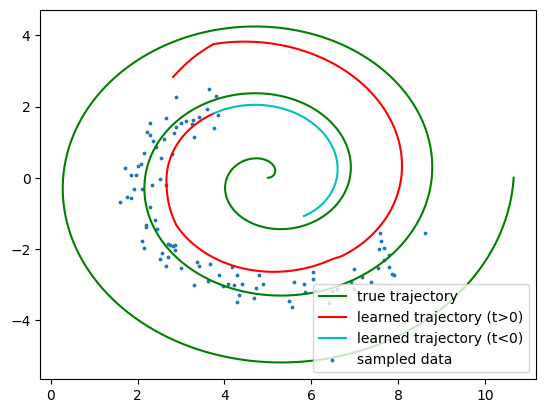

In [87]:

origs_trajs, samp_trajs, samp_ts, origs_ts = generate_spiral2d(
    nspiral=nspiral,
    start=start,
    stop=stop,
    noise_std=noise_std,
    a=a, b=b
)
with torch.no_grad():
    # sample from trajectorys' approx. posterior
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    

    # take first trajectory for visualization
    z0 = z0[0]

    ts_pos = np.linspace(0., 2. * np.pi, num=2000)
    ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
    ts_pos = torch.from_numpy(ts_pos).float().to(device)
    ts_neg = torch.from_numpy(ts_neg).float().to(device)

    zs_pos = tdf.odeint(func, z0, ts_pos)
    zs_neg = tdf.odeint(func, z0, ts_neg)

    xs_pos = dec(zs_pos)
    xs_neg = torch.flip(dec(zs_neg), dims=[0])

xs_pos = xs_pos.cpu().numpy()
xs_neg = xs_neg.cpu().numpy()
orig_traj = origs_trajs[0].cpu().numpy()
samp_traj = samp_trajs[0].cpu().numpy()

plt.figure()
plt.plot(orig_traj[:, 0], orig_traj[:, 1],
            'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
            label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
            label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[
            :, 1], label='sampled data', s=3)
plt.legend()

In [ ]:
bool(torch.rand(1) > .5)

False

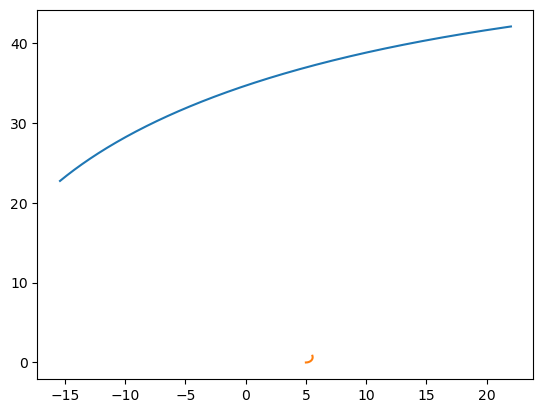

In [ ]:
generate_spiral2d()